In [481]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import matplotlib.pyplot as plt

In [482]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)

Device:  mps


In [483]:
df = pd.read_csv('https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [484]:
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

In [485]:
df.shape

(569, 31)

In [486]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [487]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [488]:
# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [489]:
X_train_tensor = torch.from_numpy(X_train).float()  # converts to float32
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1,1)  # make column vector
y_test_tensor = torch.from_numpy(y_test).float().view(-1,1)

In [490]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        # return self.features.shape[0]
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
        

In [491]:
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

In [492]:
train_dataset[0]

(tensor([-1.3224,  0.5388, -1.3153, -1.0653,  0.5487, -0.8090, -0.8509, -0.9303,
          0.8594,  0.4546,  0.0907,  3.0839, -0.0424, -0.3194,  2.4241, -0.4889,
         -0.6542, -0.4984,  1.3309,  0.3332, -1.0971,  0.8865, -1.1226, -0.8865,
          0.8596, -0.8514, -0.9891, -1.1475, -0.0170, -0.0557]),
 tensor([0.]))

In [493]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [494]:
for batch_features , batch_labels in train_dataloader:
    print(batch_features)
    print(batch_labels)
    print("---"*50)

tensor([[-1.3247e+00,  5.3421e-01, -1.3092e+00, -1.0720e+00, -1.2012e+00,
         -8.2939e-01, -6.3462e-01, -1.1246e+00, -2.0594e+00,  6.2833e-01,
         -9.9764e-01, -5.7462e-02, -8.0210e-01, -6.9917e-01, -4.9809e-01,
          1.0012e-01,  2.4523e-01, -1.0955e+00, -9.4311e-02,  3.3037e-01,
         -1.2767e+00,  3.6720e-01, -1.1847e+00, -9.8553e-01, -1.0343e+00,
         -4.0774e-01, -3.9230e-01, -1.3303e+00, -8.5778e-01,  4.2733e-01],
        [-1.1898e+00, -4.7181e-01, -1.1795e+00, -9.9785e-01,  8.6733e-01,
         -6.0208e-01, -8.8820e-01, -7.4883e-01,  5.0573e-01,  8.4075e-03,
         -6.6549e-01,  2.3890e-01, -6.3770e-01, -5.8487e-01,  8.3360e-01,
         -7.3919e-01, -8.7051e-01, -6.9156e-01,  2.4341e-01, -5.1872e-01,
         -1.1844e+00, -3.9493e-01, -1.1710e+00, -9.3365e-01,  3.8184e-01,
         -8.1684e-01, -9.8565e-01, -8.7197e-01,  1.8137e-01, -5.5046e-01],
        [-4.8175e-01, -4.2390e-01, -4.5453e-01, -5.3076e-01,  5.3450e-01,
          5.0421e-01, -3.5824e-01, -

In [495]:
# define the model
class SimpleANN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear1 = nn.Linear(num_features, 18)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(18,10)
        self.relu = nn.ReLU()
        # self.linear3 = nn.Linear(8,4)
        # self.relu = nn.ReLU()
        self.linear4 = nn.Linear(10,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        z1 = self.linear1(features)
        a1 = self.relu(z1)

        z2 = self.linear2(a1)
        a2 = self.relu(z2)
         
        # z3 = self.linear3(a2)
        # a3 = self.relu(z3)

        z4 = self.linear4(a2)
        y_pred = self.sigmoid(z4)

        return y_pred



In [496]:
model = SimpleANN(X_train_tensor.shape[1])



In [497]:
criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [498]:
# forward pass
y_pred = model(X_train_tensor)

# loss
loss = criterion(y_pred, y_train_tensor)
print("Initial loss:", loss.item())

Initial loss: 0.6919323205947876


Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [10/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [20/60], Loss: 0.6919
Epoch [30/60], Loss: 0.6919
Epoch [30/60], Loss: 0.6919
Epoch [30/60], Loss: 0.6919
Epoch [30/60], Loss: 0.6919
Epoch [30/60], Loss: 0.6919
Epoch [30/60], Loss:

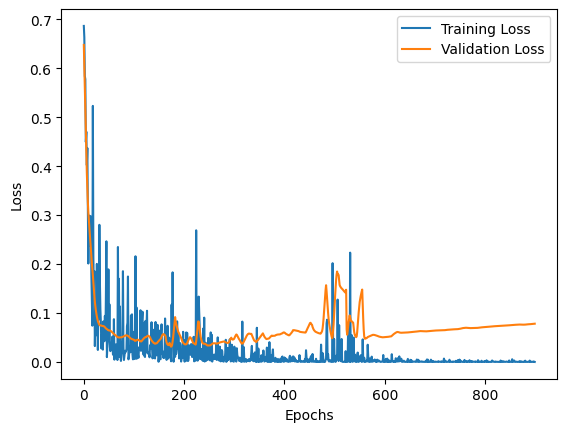

In [499]:
# running the loop
epochs = 60
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    n_train = 0
    
    for batch_features, batch_labels in train_dataloader:
      # 1. Forward pass
      y_pred = model(batch_features)
    
      # 2. Compute loss
      train_loss = criterion(y_pred, batch_labels.view(-1, 1))

      # 3. Backpropagation
      optimizer.zero_grad()
      train_loss.backward()

      # 4. Update weights
      optimizer.step()

      train_losses.append(train_loss.item())


      model.eval()
      with torch.no_grad():
        y_val_pred = model(X_test_tensor)
        val_loss = criterion(y_val_pred, y_test_tensor)
        val_losses.append(val_loss.item())

      if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
        # print("len(train_losses):", len(train_losses))
        # print("len(val_losses):", len(val_losses))


plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()